<a href="https://colab.research.google.com/github/david-j-cox/Man-vs-Machine/blob/master/Police_Stops_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background information
*   This notebooks contains the data analytic pipeline for the manuscript titled "Understanding Policing: A Quantitative Analysis" and submitted to *Perspectives on Behavior Science*.
*   Data for this notebook can be obtained from the Stanford Police Project: https://openpolicing.stanford.edu/data/. 

In [ ]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Upload data 
from google.colab import files
uploaded = files.upload()
nash_raw_data = pd.read_csv("tn_nashville_2020_04_01.csv")
nash_data = nash_raw_data.copy()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Policing Data/Nashville/Data


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,8,15,16,17,22,23,24,25,29,30,31,32,33,35,36,37,38,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Sample of what the data looks like and the data types
nash_data.head()

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,subject_sex,officer_id_hash,type,violation,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_registration_state,notes,raw_verbal_warning_issued,raw_written_warning_issued,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,232947,2010-10-10,NaN,"DOMINICAN DR & ROSA L PARKS BLVD, NASHVILLE, T...",36.187925,-86.798519,6,4403.0,611,27.0,black,male,80ed1b32eb,vehicular,investigative stop,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,investigative stop,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
1,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5,9035.0,513,18.0,white,male,a983204b21,vehicular,moving traffic violation,False,True,False,citation,NaN,NaN,NaN,False,False,False,False,NaN,moving traffic violation,TN,NaN,False,False,True,NaN,N,False,False,False,False,False,False,False
2,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1,5005.0,121,52.0,white,male,f5d8fbd78b,vehicular,vehicle equipment violation,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
3,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3,8891.0,325,25.0,white,male,4f1d028e45,vehicular,registration,False,False,True,warning,NaN,NaN,NaN,False,False,False,False,NaN,registration,TN,NaN,True,False,False,NaN,N,False,False,False,False,False,False,False
4,232780,2010-10-10,01:00:00,"BUCHANAN ST, NORTH, TN, 37208",36.180038,-86.809109,NaN,NaN,NaN,21.0,black,male,0f0e6b7d67,vehicular,vehicle equipment violation,False,False,True,warning,False,False,False,False,True,True,True,probable cause,vehicle equipment violation,TN,NaN,True,False,False,NaN,N,True,True,False,False,False,False,False


In [ ]:
# Create year and month cols for grouping
nash_data['year'] = pd.DatetimeIndex(nash_data['date']).year
nash_data['month'] = pd.DatetimeIndex(nash_data['date']).month

# Distributions of stops and putative reinforcers per month for all officers

In [ ]:
# Create individual data frames for the different independent and dependent variables
offcr_stops = nash_data.groupby(['year', 'month', 'officer_id_hash']).size()
offcr_cites = nash_data.groupby(['year', 'month', 'officer_id_hash', 'citation_issued']).size()
offcr_search = nash_data.groupby(['year', 'month', 'officer_id_hash', 'search_conducted']).size()
offcr_frisk = nash_data.groupby(['year', 'month', 'officer_id_hash', 'frisk_performed']).size()
offcr_contra = nash_data.groupby(['year', 'month', 'officer_id_hash', 'contraband_found']).size()
offcr_arrest = nash_data.groupby(['year', 'month', 'officer_id_hash', 'arrest_made']).size()

In [ ]:
# Print descriptions of each subset dataframe 
from scipy.stats import skew
grouped_data = [offcr_stops, offcr_cites, offcr_search, offcr_frisk, offcr_contra, offcr_arrest]
data_type = ['Stops', 'Citations', 'Searches', 'Frisks', 'Contraband Found', 'Arrests']

for i in range(len(grouped_data)):
  print(data_type[i], "| Skew =", round(skew(grouped_data[i]), 4), "\n", grouped_data[i].describe(), "\n")

Stops | Skew = 3.2648 
 count    85841.000000
mean        36.024044
std         45.549907
min          1.000000
25%          6.000000
50%         22.000000
75%         50.000000
max        675.000000
dtype: float64 

Citations | Skew = 3.2679 
 count    141332.000000
mean         21.877706
std          31.623313
min           1.000000
25%           3.000000
50%           9.000000
75%          30.000000
max         461.000000
dtype: float64 

Searches | Skew = 3.8236 
 count    119394.000000
mean         25.899978
std          40.414383
min           1.000000
25%           2.000000
50%           9.000000
75%          36.000000
max         675.000000
dtype: float64 

Frisks | Skew = 3.5768 
 count    106677.000000
mean         28.987673
std          42.403277
min           1.000000
25%           3.000000
50%          12.000000
75%          41.000000
max         675.000000
dtype: float64 

Contraband Found | Skew = 14.379 
 count    46182.000000
mean         2.765255
std          5.041673

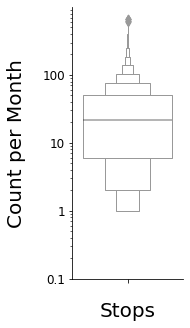

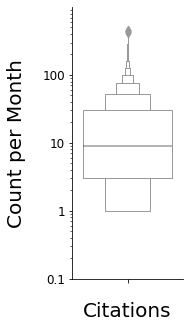

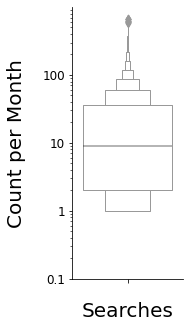

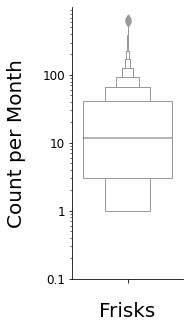

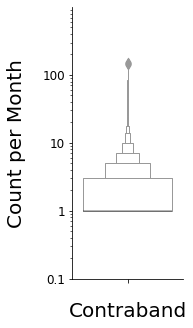

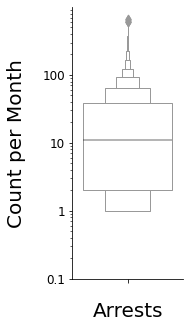

In [ ]:
# Plot letter-value plots / boxen plots of the different distributions. 
# NB: These are Figure 1 in the manuscript
def boxen(df, x_label):
  f, ax = plt.subplots(figsize=(2, 5))
  sns.boxenplot(y=df, color='white')
  plt.xlabel(x_label, fontsize=20, labelpad=(16))
  plt.ylabel('Count per Month', fontsize=20, labelpad=(16))
  plt.ylim(.1, 1000)
  plt.yscale("log")
  plt.yticks(ticks=[.1, 1, 10, 100], labels=['0.1', '1', '10', '100'], fontsize=12)
  # plt.yticks(fontsize=12)
  right_side = ax.spines["right"]
  right_side.set_visible(False)
  top = ax.spines["top"]
  top.set_visible(False)
  plt.show()

boxen(offcr_stops, 'Stops')
boxen(offcr_cites, 'Citations')
boxen(offcr_search, 'Searches')
boxen(offcr_frisk, 'Frisks')
boxen(offcr_contra, 'Contraband')
boxen(offcr_arrest, 'Arrests')

# Define single-alternative matching equation

In [ ]:
# Define single alternative matching equation and import packages we'll need to
# play with it.  
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def single_match(x, k, re):
  return (k*x)/(x+re)

# Fit single-alternative matching to each officer's data

In [ ]:
# Function for fitting single-alternative equation
def single_matching(df, unique_identifier, df_reinforcer, reinforcer_label, 
                    fit_df_name, subset_cat=None, month=False):
  """
    Function Inputs:
    ----------
    df: Dataframe from which to subset the individual officer data. 
    unique_identifier: Dataframe column containing the individual person id. 
    df_reinforcer: The column that contains the reinforcer being tested. 
    reinforcer_label: The label to assign to the reinforcer being tested. 
    fit_df_name: Name of the fit dataframe that is saved by running this function. 
    subset_cat: Column to subsetting df for fitting across different categories.
    month: True if binning by month and year. False if binning only by year. 

    DESCRIPTION: This function fits the single-altenative matching equation 
        (Herrnstein, 1970) to behavior data binned per month for every 
        officer in this dataframe. It is designed so you can run through a loop 
        and test a variety of potential reinforcers in your data set, determine 
        which one best describes each officer's data, and save the results. 

    Returns:
    -------
    None. Pandas dataframe automatically saved after every officer. The 
    auto-saved dataframe contains:
      (1) Unique officer id number
      (2) Reinforcer label
      (3) The subset category of the data for each fit (if specified)
      (4) The estimated k parameter for the single-alternative matching equation. 
      (5) The estimated Re parameter for the single-alternative matching equation. 
      (6) The variance accounted for by the single-alternative matching equation. 
  """
  import warnings
  warnings.filterwarnings('ignore')
  # Create list of all the unique officers in the dataset
  uniq_persons = df[unique_identifier].unique()
  
  # Lists for storing data
  person_num = []
  fit_type = []
  reinforcer_type = []
  k_val = []
  re_val = []
  r2_val = []
  error_list = []

  for i in uniq_persons:
    # Subset single officer data
    person_hash = i
    person_A = df[df[unique_identifier]==i]
    person_A = person_A[person_A['time'].notna()]
    person_A = person_A.reset_index()

    # Obtain rate of behavior per month and rate of citations per month
    person_reinforcer = person_A.groupby(['year', 'month'])[df_reinforcer].sum()
    person_behavior = person_A.groupby(['year', 'month']).size()

    if len(person_behavior) > 5:
      try:
        reinforcer_per_day = person_reinforcer / 30.42  # Convert to rate per day
        behavior_per_day = person_behavior / 30.42  # Convert to rate per day

        # Fit the single-alt matching equation to the officer data
        behavior = behavior_per_day.values
        reinforcer = reinforcer_per_day.values
        c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
        preds_from_obs = single_match(reinforcer, *c)  # Make predictions based on model params
        r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

        # Append data to cols
        person_num.append(person_hash)
        reinforcer_type.append(reinforcer_label)
        fit_type.append('overall')
        k_val.append(c[0])
        re_val.append(c[1])
        r2_val.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

        # Run the same analysis, but grouped by race
        # Calculate rate of behavior per day and rate of citations per day
        if month==True:
          person_reinforcer = person_A.groupby(['year', 'month', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', 'month', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 30.42
          behavior_per_day = person_behavior / 30.42
        else:
          person_reinforcer = person_A.groupby(['year', subset_cat])[df_reinforcer].sum().unstack()
          person_behavior = person_A.groupby(['year', subset_cat]).size().unstack()
          reinforcer_per_day = person_reinforcer / 12
          behavior_per_day = person_behavior / 12
        reinforcer_per_day = reinforcer_per_day.fillna(0)
        behavior_per_day = behavior_per_day.fillna(0)

        # Loop through each race and fit the model
        cols = list(reinforcer_per_day)
        race_plot = []
        k_plot = []
        re_plot = []
        r2_plot = []

        for k in cols:
          behavior = behavior_per_day[k].values
          reinforcer = reinforcer_per_day[k].values
          param_seeds = [16, 5]
          c, cov = curve_fit(single_match, reinforcer, behavior) # Fit model
          preds_from_obs = single_match(reinforcer, *c) # Make predictions based on model params
          r_2 = r2_score(behavior, preds_from_obs) # Calculate vac to see how well the model fits

          # Append data to cols
          person_num.append(person_hash)
          reinforcer_type.append(reinforcer_label)
          fit_type.append(k)
          race_plot.append(k)
          k_val.append(c[0])
          k_plot.append(c[0])
          re_val.append(c[1])
          re_plot.append(c[1])
          r2_val.append(round(r_2, 4))
          r2_plot.append(round(r_2, 4))

        # Save data
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('All_Fits_Citations.csv')
    
      except:
        error_list.append(i)
        err_officers = pd.DataFrame(error_list)
        err_officers.to_csv('Error_List_%s.csv' %reinforcer_label)
        All_Fits = pd.DataFrame({"person_num":person_num, "reinforcer":reinforcer_type, "fit_type":fit_type, "est_k":k_val, "est_re":re_val, "vac":r2_val})
        All_Fits.to_csv('%s.csv' %fit_df_name)

In [ ]:
# Citations as putative reinforcer binned by month
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='citation_issued', reinforcer_label='citations', 
                fit_df_name='All_Fits_Citations', subset_cat='subject_race', 
                month=True)

In [ ]:
# Searches as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='search_conducted', reinforcer_label='searches', 
                fit_df_name='All_Fits_Searches', subset_cat='subject_race')

In [ ]:
# Frisk as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='frisk_performed', reinforcer_label='frisks', 
                fit_df_name='All_Fits_Frisks', subset_cat='subject_race')

In [ ]:
# Contraband as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='contraband_found', reinforcer_label='contraband', 
                fit_df_name='All_Fits_Contraband', subset_cat='subject_race')

In [ ]:
# Arrests as putative reinforcers binned by year
single_matching(df=nash_data, unique_identifier='officer_id_hash', 
                df_reinforcer='arrest_made', reinforcer_label='arrests', 
                fit_df_name='All_Fits_Arrests', subset_cat='subject_race')

# Combine all fit dataframes into single dataframe

In [ ]:
# Combine all fit dataframes into single dataframe
cite_fits = pd.read_csv('All_Fits_Citations.csv')
cite_fits = cite_fits.drop(['Unnamed: 0'], axis=1)
search_fits = pd.read_csv('All_Fits_Searches.csv')
search_fits = search_fits.drop(['Unnamed: 0'], axis=1)
frisk_fits = pd.read_csv('All_Fits_Frisks.csv')
frisk_fits = frisk_fits.drop(['Unnamed: 0'], axis=1)
contra_fits = pd.read_csv('All_Fits_Contraband.csv')
contra_fits = contra_fits.drop(['Unnamed: 0'], axis=1)
arrest_fits = pd.read_csv('All_Fits_Arrests.csv')
arrest_fits = arrest_fits.drop(['Unnamed: 0'], axis=1)

all_fits = cite_fits.append([search_fits, frisk_fits, contra_fits, arrest_fits])
all_fits.to_csv('All_Single_Alt_Matching_Fits.csv')